In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

In [2]:
path = 'C://Users//Cynthia//Documents//IpParis_C//MIT//datasets'
train_path = path+'//train_features.csv'

In [3]:
train_df = pd.read_csv(train_path)
train_df.tail(1)

,AI_written,essay,roberta_base_openai_detector_probability,radar_probability,roberta_large_openai_detector_probability,text_length,formality,sentiment_label,sentiment_score,extroversion,neuroticism,agreeableness,conscientiousness,openness,personality,formality_label,length_label
19999,0,From The majority of sexual assault are not re...,0.995189,0.025088,0.926431,5331,73.825503,NEGATIVE,0.992644,0.539659,0.500195,0.510512,0.402652,0.58109,openness,formal,long


In [4]:
y_true = train_df['AI_written']  # True labels
y_pred_proba = train_df['roberta_large_openai_detector_probability'] # Predicted probabilities

In [5]:
y_true.value_counts()

1    12522
0     7478
Name: AI_written, dtype: int64

In [6]:
y_pred_proba.tail(2)

19998    0.148782
19999    0.926431
Name: roberta_large_openai_detector_probability, dtype: float64

In [7]:
def performance_by_threshold (y_pred_proba, y_true, threshold):
    # Compute the accuracy
    y_predicted = (y_pred_proba > threshold).astype(int)
    accuracy = accuracy_score(y_predicted, y_true)
    f1 = f1_score(y_true, y_predicted)
    
    # Percentage of data below and above the threshold
    data_below_threshold = (y_pred_proba <= threshold).mean() * 100
    data_above_threshold = (y_pred_proba > threshold).mean() * 100
    
    return accuracy, f1, data_below_threshold, data_above_threshold

In [8]:
def evaluate_thresholds(train_df, label):
    y_true = train_df['AI_written']  # True labels
    y_pred_proba = train_df['roberta_large_openai_detector_probability'] # Predicted probabilities
    thresholds = np.arange(0.0, 1.01, 0.01)
    results = []

    for threshold in thresholds:
        accuracy, f1, data_below_threshold, data_above_threshold = performance_by_threshold (y_pred_proba, y_true, threshold)
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'f1': f1,
            'perc_below_threshold': data_below_threshold,
            'perc_above_threshold': data_above_threshold
        })


    # Static threshold
    static_threshold = 0.5
    #y_pred_static = (y_pred_proba > static_threshold).astype(int)
    #static_accuracy = accuracy_score(y_pred_static, y_true)
    #static_f1 = f1_score(y_pred_static, y_true)

    static_accuracy, static_f1, static_data_below_threshold, static_data_above_threshold = performance_by_threshold (y_pred_proba, y_true, static_threshold)
    results.append({
        'threshold': static_threshold,
        'accuracy': static_accuracy,
        'f1': static_f1,
        'perc_below_threshold': static_data_below_threshold,
        'perc_above_threshold': static_data_above_threshold
    })

    # ROC-based threshold
    """
    ROC curve is a graphical representation used to evaluate the performance of a binary classification model.
    It shows the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR)
        at various threshold settings.
    ROC curve visualizes the model's trade-offs between TPR and FPR at different thresholds.
    AUC summarizes the quality of the ROC curve into a single number (closer to 1 is better).
    """
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_best_idx = np.argmax(tpr - fpr)
    roc_threshold = roc_thresholds[roc_best_idx]
    #y_pred_roc = (y_pred_proba > roc_best_threshold).astype(int)
    #roc_best_accuracy = accuracy_score(y_pred_roc, y_true)
    #roc_best_f1 = f1_score(y_pred_roc, y_true)

    roc_accuracy, roc_f1, roc_data_below_threshold, roc_data_above_threshold = performance_by_threshold (y_pred_proba, y_true, roc_threshold)
    results.append({
        'threshold': roc_threshold,
        'accuracy': roc_accuracy,
        'f1': roc_f1,
        'perc_below_threshold': roc_data_below_threshold,
        'perc_above_threshold': roc_data_above_threshold
    })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='threshold', ascending=True)
    results_df = results_df.drop_duplicates(subset='threshold', keep='first')
    results_df = results_df.reset_index(drop=True)

    # Plot
    plt.figure(figsize=(7, 4.5))
    plt.plot(results_df['threshold'], results_df['accuracy'], marker='o', label='Accuracy')
    plt.plot(results_df['threshold'], results_df['f1'], marker='o', label='F1')
    plt.axvline(static_threshold, color='orange', linestyle='--', label=f'Static Threshold: {static_threshold:.2f} (Acc={static_accuracy:.2f}) (F1={static_f1:.2f})')
    plt.axvline(roc_threshold, color='green', linestyle='--', label=f'ROC Threshold: {roc_threshold:.2f} (Acc={roc_accuracy:.2f}) (F1={roc_f1:.2f})')
    plt.title(f'Accuracy vs Threshold - {label}')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid()
    plt.show()

    # Show the results including the percentages
    print(results_df[results_df['threshold'].isin([static_threshold, roc_threshold])])
    
    return static_threshold, static_accuracy, static_f1, static_data_above_threshold, static_data_below_threshold, roc_threshold, roc_accuracy, roc_f1, roc_data_above_threshold, roc_data_below_threshold


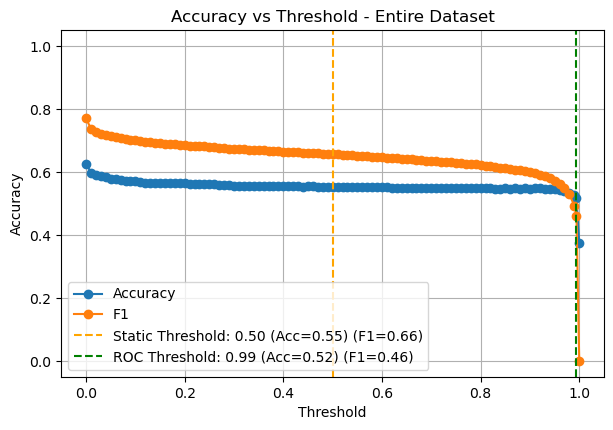

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000   0.55360  0.656615                32.610                67.390
100   0.994417   0.51675  0.461410                72.885                27.115


In [9]:
results = []
a, b, c, d, e, f, g, h, i, j = evaluate_thresholds(train_df, 'Entire Dataset')

results.append({
    'group': 'G0',
    'label': 'entire_dataset',
    'static_threshold': a,
    'static_accuracy': b,
    'static_f1': c,
    'static_data_above_threshold': d,
    'static_data_below_threshold': e,
    'roc_threshold': f,
    'roc_accuracy': g,
    'roc_f1': h,
    'roc_data_above_threshold': i,
    'roc_data_below_threshold': j
    })

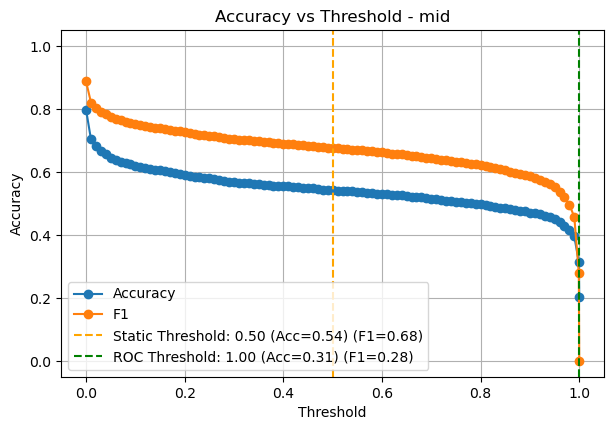

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.542211  0.675995             38.472901             61.527099
100   0.999159  0.313942  0.279475             84.547211             15.452789


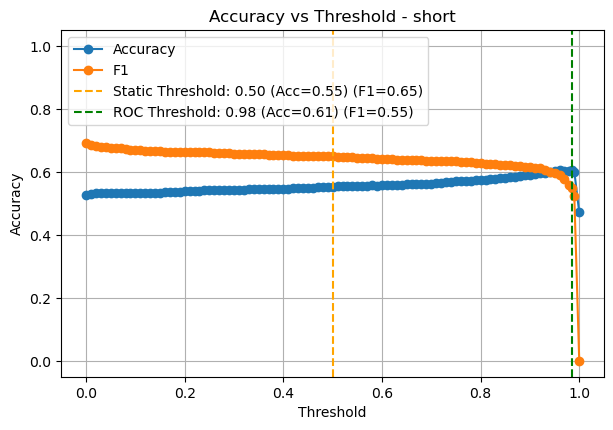

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000  0.553632  0.649261             25.576923             74.423077
99   0.984351  0.605235  0.549665             65.181624             34.818376


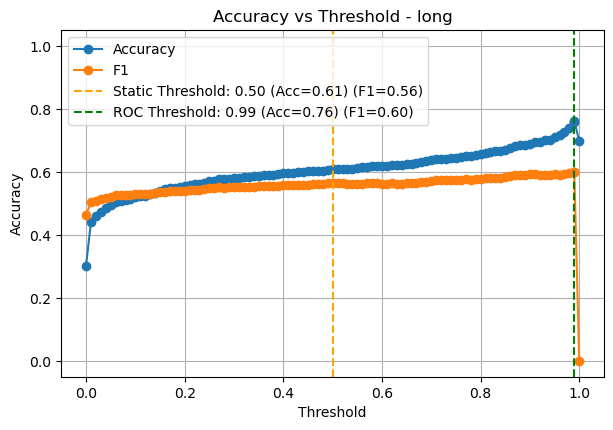

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000  0.607939  0.563823             40.348015             59.651985
99   0.988555  0.759652  0.601083             69.983687             30.016313


In [10]:
length_labels = train_df['length_label'].unique()
for label in length_labels:
    group = train_df[train_df['length_label'] == label]
    a, b, c, d, e, f, g, h, i, j = evaluate_thresholds(group, label)
    results.append({
        'group': 'G1',
        'label': label,
        'static_threshold': a,
        'static_accuracy': b,
        'static_f1': c,
        'static_data_above_threshold': d,
        'static_data_below_threshold': e,
        'roc_threshold': f,
        'roc_accuracy': g,
        'roc_f1': h,
        'roc_data_above_threshold': i,
        'roc_data_below_threshold': j
        })
    

In [11]:
train_df.columns

Index(['AI_written', 'essay', 'roberta_base_openai_detector_probability',
       'radar_probability', 'roberta_large_openai_detector_probability',
       'text_length', 'formality', 'sentiment_label', 'sentiment_score',
       'extroversion', 'neuroticism', 'agreeableness', 'conscientiousness',
       'openness', 'personality', 'formality_label', 'length_label'],
      dtype='object')

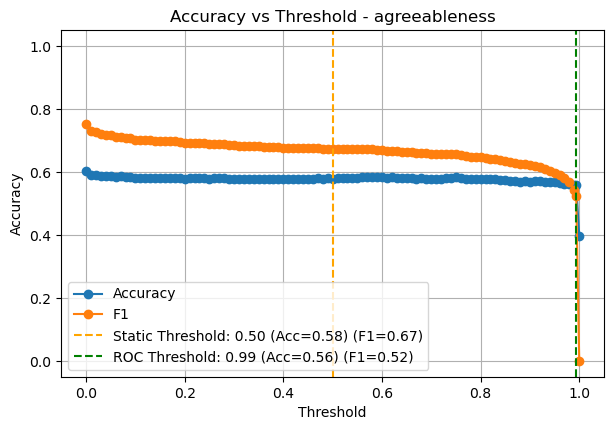

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.578663  0.672476             31.542327             68.457673
100   0.993845  0.558175  0.524740             67.220719             32.779281


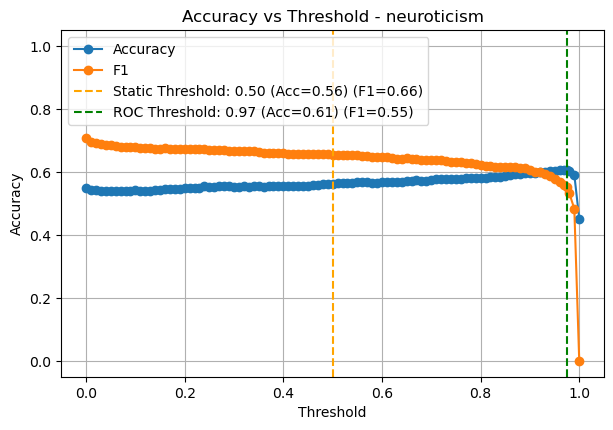

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000  0.562891  0.655451             27.973819             72.026181
98   0.974779  0.607570  0.551545             67.330677             32.669323


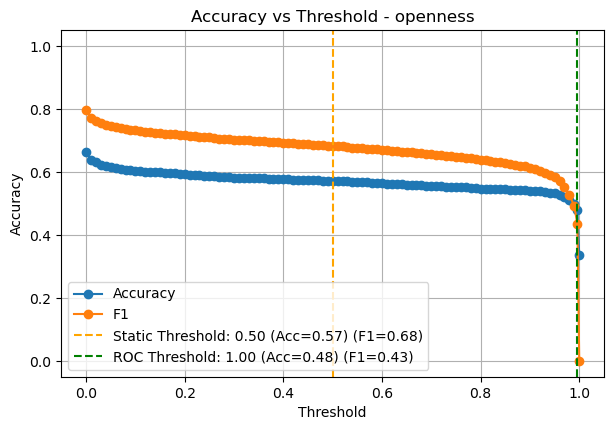

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.572065  0.682968             31.441297             68.558703
100   0.996208  0.478301  0.434793             74.120603             25.879397


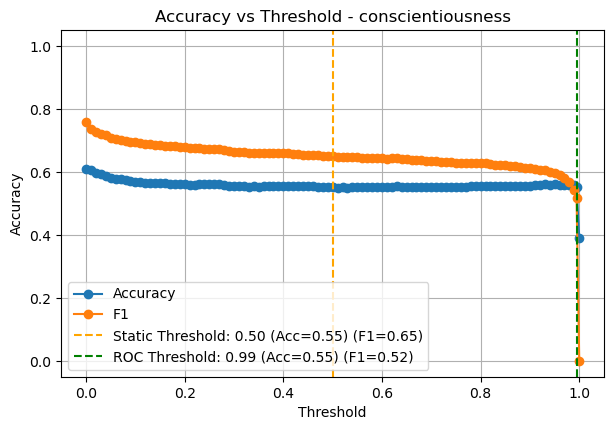

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.551555  0.649245             33.122120             66.877880
100   0.994602  0.552995  0.516511             68.519585             31.480415


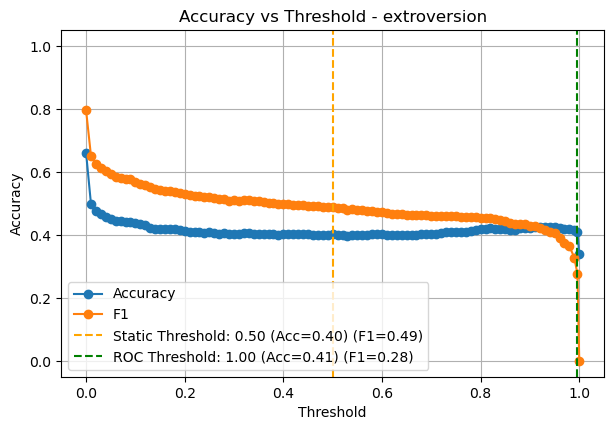

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.402753  0.489775             49.072412             50.927588
100   0.996398  0.408737  0.275660             84.500299             15.499701


In [12]:
personality_labels = train_df['personality'].unique()
for label in personality_labels:
    group = train_df[train_df['personality'] == label]
    a, b, c, d, e, f, g, h, i, j = evaluate_thresholds(group, label)
    results.append({
        'group': 'G2',
        'label': label,
        'static_threshold': a,
        'static_accuracy': b,
        'static_f1': c,
        'static_data_above_threshold': d,
        'static_data_below_threshold': e,
        'roc_threshold': f,
        'roc_accuracy': g,
        'roc_f1': h,
        'roc_data_above_threshold': i,
        'roc_data_below_threshold': j
        })

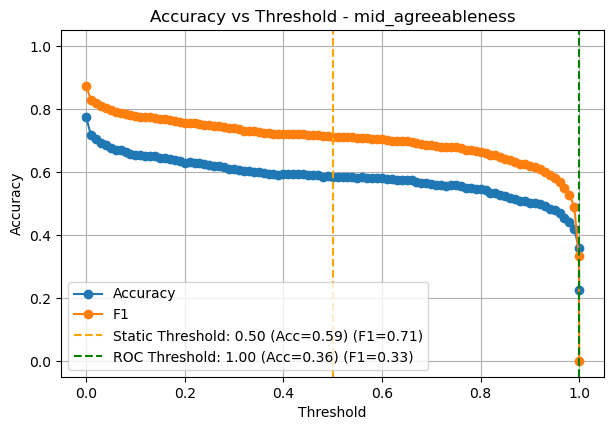

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.585028  0.711254             33.733826             66.266174
100   0.999192  0.357671  0.332373             81.238447             18.761553


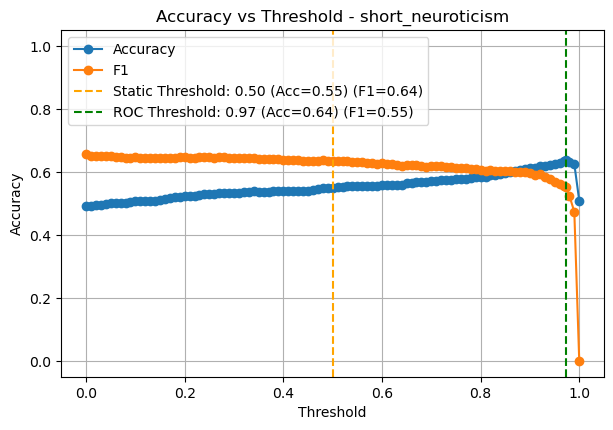

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.50000  0.550582  0.635193             25.907649             74.092351
98    0.97289  0.637293  0.552803             67.994360             32.005640


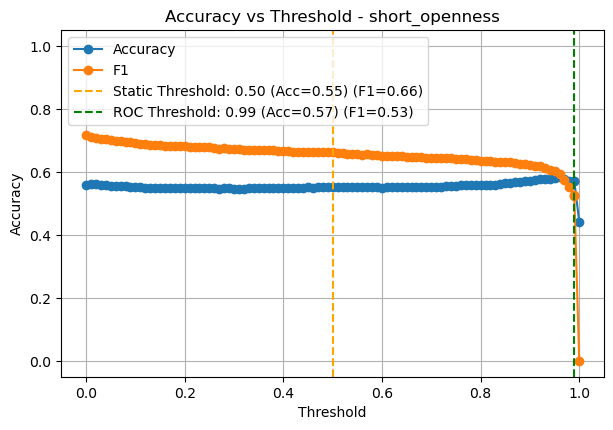

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000  0.552898  0.661843             23.607203             76.392797
99   0.989958  0.571750  0.526447             65.391109             34.608891


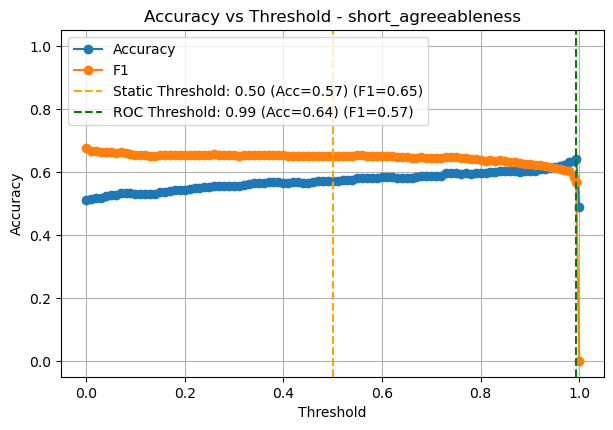

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.571206  0.649268             28.715953             71.284047
100   0.993845  0.639689  0.568500             67.470817             32.529183


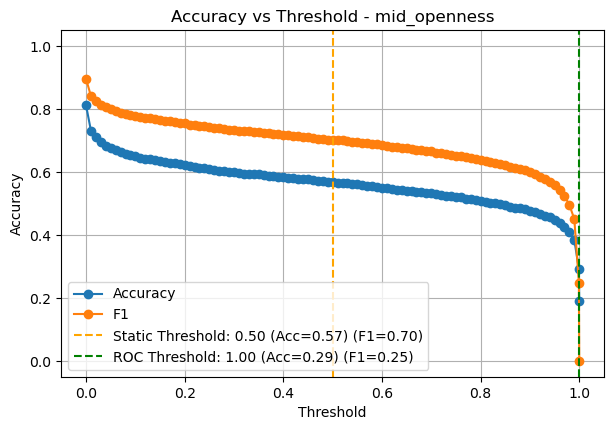

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.567330  0.702134             35.863026             64.136974
100   0.999289  0.291763  0.248834             86.834799             13.165201


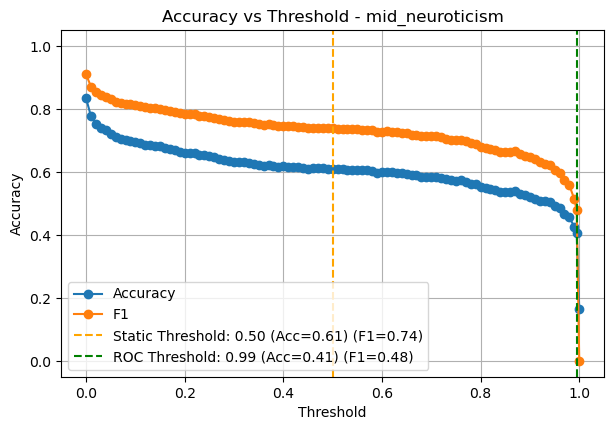

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.610845  0.739316             34.130781             65.869219
100   0.994779  0.405104  0.479777             69.059011             30.940989


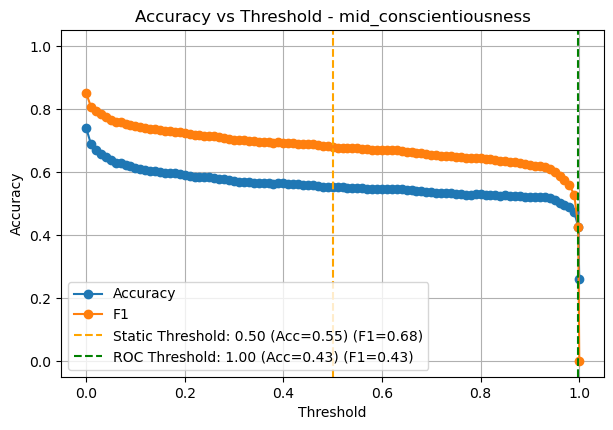

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50     0.50000  0.552795  0.679525             34.523810             65.476190
100    0.99798  0.425983  0.425091             74.223602             25.776398


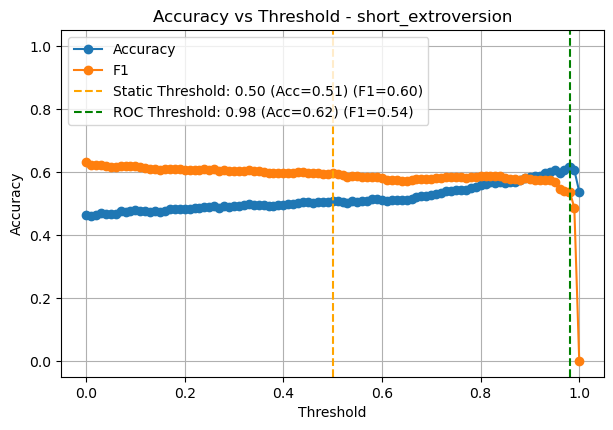

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000  0.508796  0.596218             24.627876             75.372124
99   0.980987  0.615697  0.535948             63.464141             36.535859


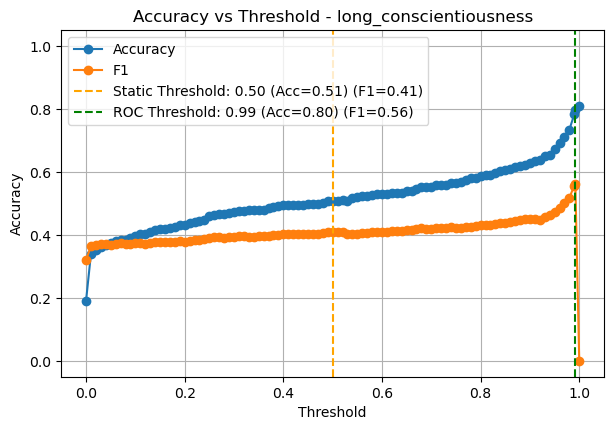

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.507563  0.408081             35.966387             64.033613
100   0.992086  0.796639  0.563177             72.605042             27.394958


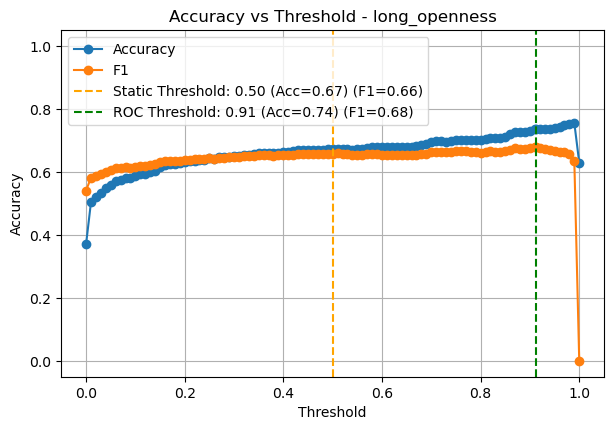

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000  0.672727  0.657957             41.363636             58.636364
92   0.911595  0.736364  0.677778             55.227273             44.772727


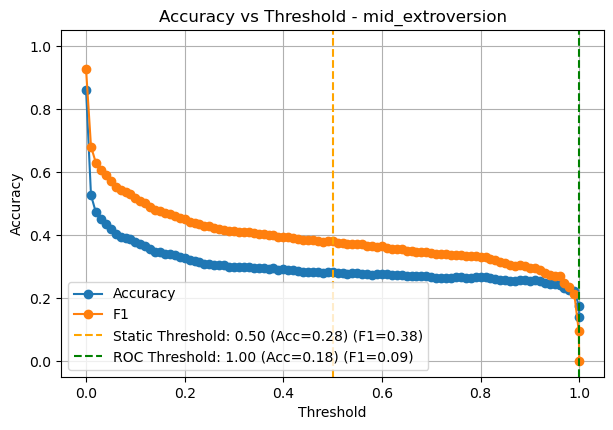

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.281623  0.379381             70.405728             29.594272
100   0.999104  0.175418  0.094364             95.107399              4.892601


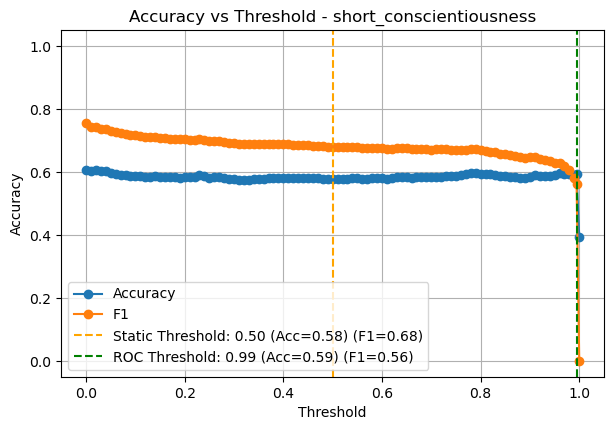

     threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50    0.500000  0.576720  0.679487             28.465608             71.534392
100   0.994638  0.592593  0.561003             67.724868             32.275132


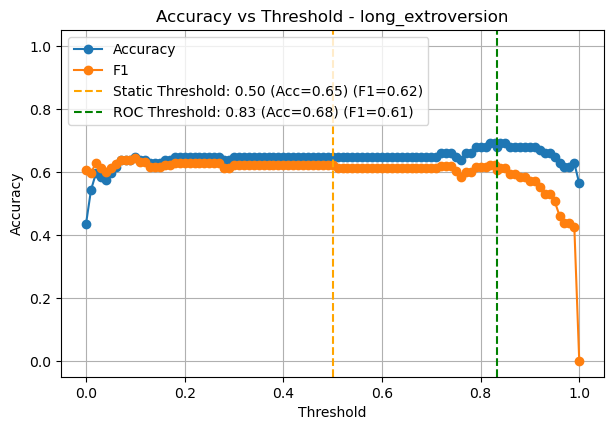

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000  0.648936  0.620690             51.063830             48.936170
84   0.832801  0.680851  0.605263             62.765957             37.234043


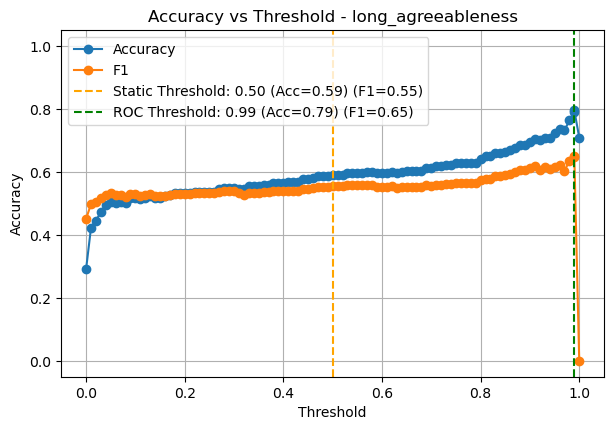

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000  0.590909  0.554455             37.272727             62.727273
99   0.989842  0.790909  0.646154             70.000000             30.000000


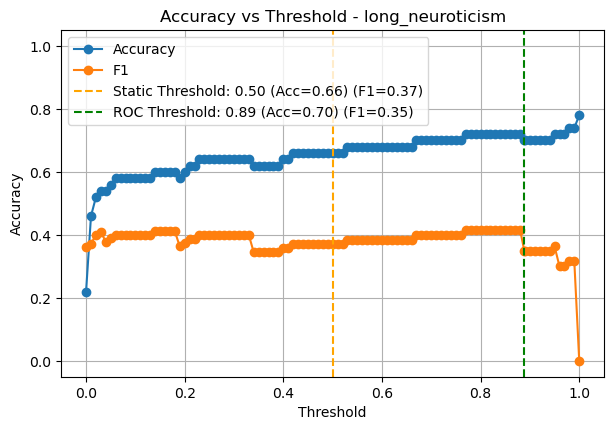

    threshold  accuracy        f1  perc_below_threshold  perc_above_threshold
50   0.500000      0.66  0.370370                  68.0                  32.0
89   0.888871      0.70  0.347826                  76.0                  24.0


In [13]:
train_df['length_personality'] = train_df['length_label'] + '_' + train_df['personality']

length_personality_labels = train_df['length_personality'].unique()
for label in length_personality_labels:
    group = train_df[train_df['length_personality'] == label]
    a, b, c, d, e, f, g, h, i, j = evaluate_thresholds(group, label)
    results.append({
        'group': 'G3',
        'label': label,
        'static_threshold': a,
        'static_accuracy': b,
        'static_f1': c,
        'static_data_above_threshold': d,
        'static_data_below_threshold': e,
        'roc_threshold': f,
        'roc_accuracy': g,
        'roc_f1': h,
        'roc_data_above_threshold': i,
        'roc_data_below_threshold': j
        })

In [14]:
train_df['length_personality'].value_counts()

mid_openness               4322
short_openness             3554
short_neuroticism          2837
mid_conscientiousness      1932
short_agreeableness        1285
mid_agreeableness          1082
short_conscientiousness     945
long_openness               880
mid_extroversion            838
short_extroversion          739
mid_neuroticism             627
long_conscientiousness      595
long_agreeableness          220
long_extroversion            94
long_neuroticism             50
Name: length_personality, dtype: int64

In [15]:
value_counts = train_df['length_personality'].value_counts().reset_index()
value_counts.columns = ['length_personality', 'count']
value_counts['percentage'] = (value_counts['count'] / len(train_df)) * 100
value_counts

,length_personality,count,percentage
0,mid_openness,4322,21.610
1,short_openness,3554,17.770
2,short_neuroticism,2837,14.185
3,mid_conscientiousness,1932,9.660
4,short_agreeableness,1285,6.425
5,mid_agreeableness,1082,5.410
6,short_conscientiousness,945,4.725
7,long_openness,880,4.400
8,mid_extroversion,838,4.190
9,short_extroversion,739,3.695


In [16]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['group', 'label'], ascending=True)
results_df = results_df.drop_duplicates(subset=['group', 'label'], keep='first')
results_df = results_df.reset_index(drop=True)

In [17]:
results_df

,group,label,static_threshold,static_accuracy,static_f1,static_data_above_threshold,static_data_below_threshold,roc_threshold,roc_accuracy,roc_f1,roc_data_above_threshold,roc_data_below_threshold
0,G0,entire_dataset,0.5,0.553600,0.656615,67.390000,32.610000,0.994417,0.516750,0.461410,27.115000,72.885000
1,G1,long,0.5,0.607939,0.563823,59.651985,40.348015,0.988555,0.759652,0.601083,30.016313,69.983687
2,G1,mid,0.5,0.542211,0.675995,61.527099,38.472901,0.999159,0.313942,0.279475,15.452789,84.547211
3,G1,short,0.5,0.553632,0.649261,74.423077,25.576923,0.984351,0.605235,0.549665,34.818376,65.181624
4,G2,agreeableness,0.5,0.578663,0.672476,68.457673,31.542327,0.993845,0.558175,0.524740,32.779281,67.220719
5,G2,conscientiousness,0.5,0.551555,0.649245,66.877880,33.122120,0.994602,0.552995,0.516511,31.480415,68.519585
6,G2,extroversion,0.5,0.402753,0.489775,50.927588,49.072412,0.996398,0.408737,0.275660,15.499701,84.500299
7,G2,neuroticism,0.5,0.562891,0.655451,72.026181,27.973819,0.974779,0.607570,0.551545,32.669323,67.330677
8,G2,openness,0.5,0.572065,0.682968,68.558703,31.441297,0.996208,0.478301,0.434793,25.879397,74.120603
9,G3,long_agreeableness,0.5,0.590909,0.554455,62.727273,37.272727,0.989842,0.790909,0.646154,30.000000,70.000000


In [18]:
results_df.columns

Index(['group', 'label', 'static_threshold', 'static_accuracy', 'static_f1',
       'static_data_above_threshold', 'static_data_below_threshold',
       'roc_threshold', 'roc_accuracy', 'roc_f1', 'roc_data_above_threshold',
       'roc_data_below_threshold'],
      dtype='object')

In [19]:
results_df.groupby(['group', 'label']).agg(
    min_accuracy=('static_accuracy', lambda x: min(x.min(), results_df.loc[x.index, 'roc_accuracy'].min())),
    min_f1=('static_f1', lambda x: min(x.min(), results_df.loc[x.index, 'roc_f1'].min()))
).reset_index()

,group,label,min_accuracy,min_f1
0,G0,entire_dataset,0.516750,0.461410
1,G1,long,0.607939,0.563823
2,G1,mid,0.313942,0.279475
3,G1,short,0.553632,0.549665
4,G2,agreeableness,0.558175,0.524740
5,G2,conscientiousness,0.551555,0.516511
6,G2,extroversion,0.402753,0.275660
7,G2,neuroticism,0.562891,0.551545
8,G2,openness,0.478301,0.434793
9,G3,long_agreeableness,0.590909,0.554455
